<a href="https://colab.research.google.com/github/suhas-arun/NLP-CW/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from dont_patronize_me import DontPatronizeMe

import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

# Download dataset

In [ ]:
dpm = DontPatronizeMe(".", ".")
dpm.load_task1()
dpm.train_task1_df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [ ]:
trids = pd.read_csv("train_semeval_parids-labels.csv")
teids = pd.read_csv("dev_semeval_parids-labels.csv")

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

### Build internal training and dev sets


In [ ]:
def get_data_for_ids(ids, data):
    rows = []
    for _, row in ids.iterrows():
        par_id = row["par_id"]
        data_row = data[data["par_id"] == par_id]
        keyword = data_row["keyword"].values[0]
        country = data_row["country"].values[0]
        text = data_row["text"].values[0]
        label = data_row["label"].values[0]
        rows.append({
            "par_id": par_id,
            "keyword": keyword,
            "country": country,
            "text": text,
            "label": label,
        })
    return pd.DataFrame(rows)

In [ ]:
train_data = get_data_for_ids(trids, dpm.train_task1_df)
train_data

,par_id,keyword,country,text,label
0,4341,poor-families,gb,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,za,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,lk,The next immediate problem that cropped up was...,1
3,8279,vulnerable,nz,Far more important than the implications for t...,1
4,1164,poor-families,gh,To strengthen child-sensitive social protectio...,1
...,...,...,...,...,...
8370,8380,refugee,gb,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,ke,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,pk,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,pk,You have to see it from my perspective . I may...,0


In [ ]:
dev_data = get_data_for_ids(teids, dpm.train_task1_df)
dev_data

,par_id,keyword,country,text,label
0,4046,hopeless,us,We also know that they can benefit by receivin...,1
1,1279,refugee,ng,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,ng,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,ie,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,pk,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...,...
2089,10462,homeless,gh,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,pk,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,ie,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0


# Data Analysis

### Label Distribution


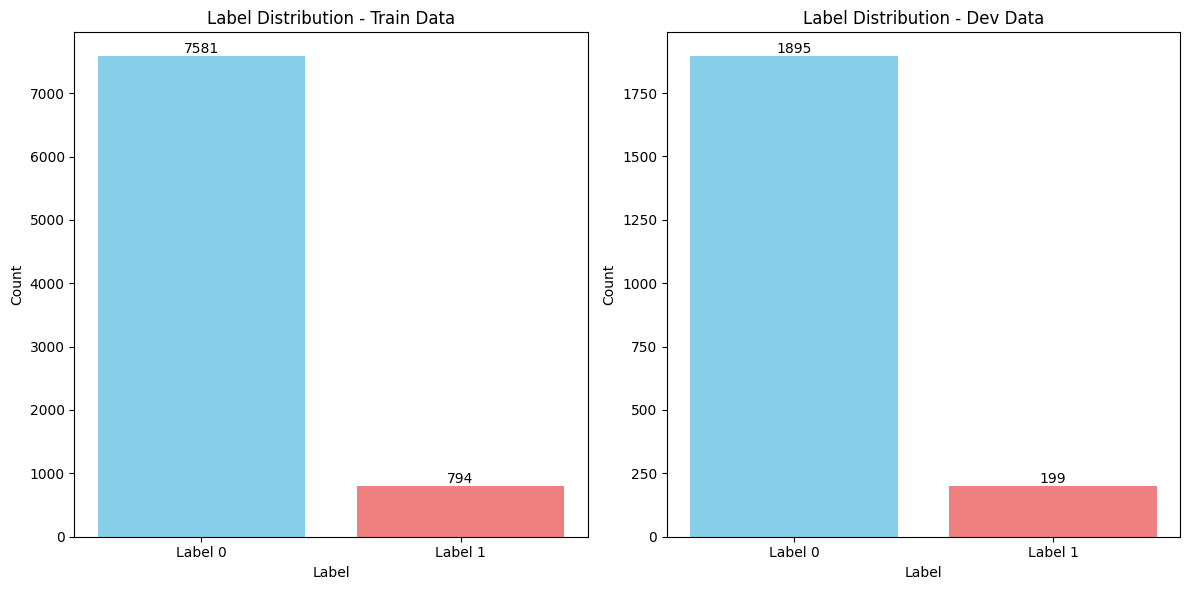

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train data plot
train_label_counts = train_data['label'].value_counts()
axes[0].bar(train_label_counts.index, train_label_counts.values, color=['skyblue', 'lightcoral'])
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Label 0', 'Label 1'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title("Label Distribution - Train Data")

for i, count in enumerate(train_label_counts.values):
    axes[0].text(i, count + 0.1, str(count), ha='center', va='bottom')

# Dev data plot
dev_label_counts = dev_data['label'].value_counts()
axes[1].bar(dev_label_counts.index, dev_label_counts.values, color=['skyblue', 'lightcoral'])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Label 0', 'Label 1'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title("Label Distribution - Dev Data")

for i, count in enumerate(dev_label_counts.values):
    axes[1].text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Data Preprocessing

In [22]:
# Preprocess text function

# Download nltk packages
nltk.download("stopwords")
nltk.download("punkt_tab")

def preprocess(text):
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric chars
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # Remove stopwords
    words = TextBlob(text).words
    filtered_words = [w for w in words if w.lower() not in stopwords.words("english")]
    text = " ".join(filtered_words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [23]:
# Text after preprocessing
train_data["text"][0]

'scheme saw estimated 150 000 children poor families sent parts british empire 1920 1974 religious orders charities said would lead better lives'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.text = df["text"]
        self.labels = df["label"]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.text[index],
            padding="max_length",
            truncation=True,
            max_length=512,
        )
        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item


# DeBERTa Model


In [ ]:
torch.cuda.empty_cache()

In [ ]:
deberta_model_name = "microsoft/deberta-v3-base"
deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)
deberta_model = AutoModelForSequenceClassification.from_pretrained(deberta_model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Preprocess train/dev data and initialise custom datasets

train_data["text"] = (train_data["text"].apply(preprocess))
dev_data["text"] = (dev_data["text"].apply(preprocess))

deberta_train_dataset = CustomDataset(train_data, deberta_tokenizer)
deberta_dev_dataset = CustomDataset(dev_data, deberta_tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
def train_model(model, train_loader, dev_loader, criterion, optimiser, num_epochs, progress_bar=None):
    train_losses = []
    train_f1_scores = []
    dev_losses = []
    dev_f1_scores = []

    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
            optimiser.zero_grad()
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_f1 = f1_score(train_labels, train_preds)
        train_f1_scores.append(train_f1)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")

        model.eval()
        dev_loss = 0.0
        dev_preds = []
        dev_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc=f"Validating Epoch {epoch + 1}", leave=False):
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs).logits
                loss = criterion(outputs, labels)
                dev_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                dev_preds.extend(preds.cpu().numpy())
                dev_labels.extend(labels.cpu().numpy())

        dev_loss /= len(dev_loader)
        dev_losses.append(dev_loss)

        dev_f1 = f1_score(dev_labels, dev_preds)
        dev_f1_scores.append(dev_f1)

        print(f"Epoch {epoch + 1}/{num_epochs}, Dev Loss: {dev_loss:.4f}, Dev F1: {dev_f1:.4f}")

        if progress_bar:
            progress_bar.value = epoch + 1  # Update progress bar
            progress_bar.description = f"Epoch {epoch + 1}/{num_epochs}"

    return train_losses, dev_losses, train_f1_scores, dev_f1_scores

In [26]:
lr = 1e-5
num_epochs = 5
batch_size = 4

deberta_train_loader = DataLoader(deberta_train_dataset, batch_size, shuffle=True)
deberta_dev_loader = DataLoader(deberta_dev_dataset, batch_size)

deberta_model.to(device)
print("Num params:", sum(p.numel() for p in deberta_model.parameters()))

Num params: 184423682


In [ ]:
progress_bar = widgets.IntProgress(min=0, max=num_epochs)
display(progress_bar)

optimiser = torch.optim.Adam(deberta_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.9)

train_losses, dev_losses, train_f1_scores, dev_f1_scores = train_model(
    deberta_model,
    deberta_train_loader,
    deberta_dev_loader,
    criterion,
    optimiser,
    num_epochs,
    progress_bar
)

IntProgress(value=0, max=5)

Epoch 1/5, Train Loss: 0.1068, Train F1: 0.7742


Epoch 1/5, Dev Loss: 0.2941, Dev F1: 0.4466


Epoch 2/5, Train Loss: 0.0691, Train F1: 0.8686


Epoch 2/5, Dev Loss: 0.3403, Dev F1: 0.4944


Training Epoch 3:  62%|██████▏   | 1304/2094 [11:41<07:03,  1.86it/s]